In [1]:
# Install SAM and necessary dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

torch.cuda.is_available()

Mounted at /content/drive


True

In [3]:
# CHECKPOINT downloading
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-07-16 10:14:09--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.102, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  99.1MB/s    in 21s     

2024-07-16 10:14:29 (117 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [4]:
# Define model type and checkpoint path
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"

# Load the model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Init mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

In [5]:
# # https://www.freecodecamp.org/news/use-segment-anything-model-to-create-masks/

# # Give the path of your image
# IMAGE_PATH= '/content/drive/MyDrive/KernelGAN-Masks/imgs/img1/img1_lr.png'
# # Read the image from the path
# image= cv2.imread(IMAGE_PATH)
# # Convert to RGB format
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# # Generate segmentation mask
# output_mask = mask_generator.generate(image_rgb)
# # print(output_mask)

# # Function that inputs the output and plots image and mask
# def create_masks(result_dict, axes=None, masks_num=None):
#     if axes:
#       ax = axes
#     else:
#       ax = plt.gca()
#       ax.set_autoscale_on(False)
#     if not masks_num:
#       masks_num = len(result_dict)
#     sorted_result = sorted(result_dict, key=lambda x: x['area'], reverse=True)
#     sorted_result = sorted_result[:masks_num]
#     # Plot for each segment area
#     for val in sorted_result:
#       mask = val['segmentation']
#       img = np.ones((mask.shape[0], mask.shape[1], 3))
#       color_mask = np.random.random((1, 3)).tolist()[0]
#       for i in range(3):
#           img[:,:,i] = color_mask[i]
#           ax.imshow(np.dstack((img, mask*0.5)))
#     return sorted_result


# _,axes = plt.subplots(1,2, figsize=(16,16))
# axes[0].imshow(image_rgb)
# masks = create_masks(output_mask, axes[1],2)

In [6]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# def extract_largest_component(mask):
#     # Convert boolean array to a binary image (0 and 255)
#     true_map_binary = (mask * 255).astype(np.uint8)

#     # Apply morphological operations to remove small noise
#     kernel = np.ones((10, 10), np.uint8)
#     true_map_binary = cv2.morphologyEx(true_map_binary, cv2.MORPH_CLOSE, kernel)

#     # Use connectedComponentsWithStats to find all connected components
#     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(true_map_binary)

#     # The first component is the background, so we start with the second one
#     largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

#     # Create a new mask for the largest component
#     largest_component_mask = (labels == largest_component).astype(np.uint8) * 255

#     return largest_component_mask

# # Example usage:
# masl = masks[0]['segmentation']  # Replace with your actual mask
# largest_component_mask = extract_largest_component(masl)

# # Display the new clean mask and its negative with boundaries
# plt.figure(figsize=(12, 6))

# # Plot for largest component mask
# plt.subplot(1, 2, 1)
# plt.imshow(largest_component_mask, cmap='gray')
# plt.title('Largest Component Mask')
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.gca().spines['top'].set_linewidth(2)
# plt.gca().spines['bottom'].set_linewidth(2)
# plt.gca().spines['left'].set_linewidth(2)
# plt.gca().spines['right'].set_linewidth(2)

# # Plot for negative of largest component mask
# plt.subplot(1, 2, 2)
# plt.imshow(255 - largest_component_mask, cmap='gray')
# plt.title('Negative of Largest Component Mask')
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.gca().spines['top'].set_linewidth(2)
# plt.gca().spines['bottom'].set_linewidth(2)
# plt.gca().spines['left'].set_linewidth(2)
# plt.gca().spines['right'].set_linewidth(2)

# plt.tight_layout()
# plt.show()


/content/drive/MyDrive/KernelGAN-Masks/imgs/img1
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/imgs/img2
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/imgs/img3
/content/drive/MyDrive/KernelGAN-Masks/masks/img3/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img3/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img3/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img3/obj_lr_mask.png


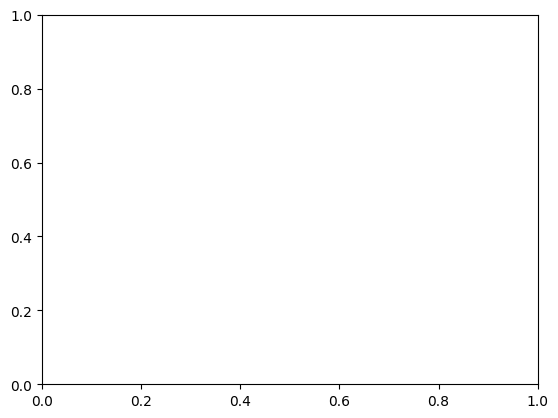

In [7]:
# @title קוד הרלוונטי

def create_blocky_mask(img):
   scale_factor = 0.2
   small_lr_back = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
   blocky_lr_back = cv2.resize(small_lr_back, lr_back.shape[::-1], interpolation=cv2.INTER_NEAREST)
   return blocky_lr_back


# Assuming mask_generator is an instance of some class capable of generating masks
def extract_numbers_from_filename(filename):
    # Use regular expression to find numbers in the filename
    match = re.search(r'\d+', filename)

    # If numbers are found, convert them to an integer
    if match:
        return int(match.group())
    else:
        return None

def create_masks(result_dict, axes=None, masks_num=None):
    if axes:
      ax = axes
    else:
      ax = plt.gca()
      ax.set_autoscale_on(False)
    if not masks_num:
      masks_num = len(result_dict)
    sorted_result = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    sorted_result = sorted_result[:masks_num]
    return sorted_result


def extract_largest_component(mask):
    # Convert boolean array to a binary image (0 and 255)
    true_map_binary = (mask * 255).astype(np.uint8)

    # Apply morphological operations to remove small noise
    kernel = np.ones((10, 10), np.uint8)
    true_map_binary = cv2.morphologyEx(true_map_binary, cv2.MORPH_CLOSE, kernel)

    # Use connectedComponentsWithStats to find all connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(true_map_binary)

    # The first component is the background, so we start with the second one
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create a new mask for the largest component
    largest_component_mask = (labels == largest_component).astype(np.uint8) * 255

    return largest_component_mask

def create_mask(image_path):
    image_rgb = cv2.imread(image_path)

      # Generate segmentation mask
    output_mask = mask_generator.generate(image_rgb)

            # Create a mask for the largest component
    masks = create_masks(output_mask)
    mask = masks[0]['segmentation']
    largest_component_mask = extract_largest_component(mask)
    return largest_component_mask

# do the code aobve for all the imgs in the src folder
base = "/content/drive/MyDrive/KernelGAN-Masks"
src = base + "/imgs"
dst = base + "/masks"

files = os.listdir(src)

for file_name in files:
    image_path = os.path.join(src, file_name)
    img_num = extract_numbers_from_filename(file_name)
    dir_path = os.path.join(dst, 'img' + str(img_num))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print(image_path)

    for img in os.listdir(image_path):
        if "lr" in img:
            image_path_lr = os.path.join(image_path, img)
            break

    lr_back = create_mask(image_path_lr)
    new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
    new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
    new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
    new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

    hr_back = cv2.resize(lr_back, dsize=(lr_back.shape[1]*2, lr_back.shape[0]*2), interpolation=cv2.INTER_NEAREST)
    hr_obj = cv2.bitwise_not(hr_back)
    lr_obj = cv2.bitwise_not(lr_back)

    cv2.imwrite(new_path_back_hr,create_blocky_mask(hr_back))
    cv2.imwrite(new_path_back_lr, create_blocky_mask(lr_back))
    cv2.imwrite(new_path_obj_hr, create_blocky_mask(hr_obj))
    cv2.imwrite(new_path_obj_lr, create_blocky_mask(lr_obj))

    print(new_path_back_hr)
    print(new_path_back_lr)
    print(new_path_obj_hr)
    print(new_path_obj_lr)


In [8]:
# # prompt: put theblockymask on the real imge

# import matplotlib.pyplot as plt
# def apply_blocky_mask(image_path, mask_path):
#   """
#   Applies a blocky mask to an image.

#   Args:
#     image_path: Path to the input image.
#     mask_path: Path to the blocky mask.

#   Returns:
#     The image with the blocky mask applied.
#   """

#   # Load the image and mask
#   image = cv2.imread(image_path)
#   mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#   # Apply the mask to the image
#   masked_image = cv2.bitwise_and(image, image, mask=mask)

#   return masked_image

# # Example usage:
# image_path = '/content/drive/MyDrive/KernelGAN-Masks/imgs/img5/img5_lr.png'
# mask_path = '/content/drive/MyDrive/KernelGAN-Masks/masks/img5/blocky_lr_obj_mask.png'
# masked_image = apply_blocky_mask(image_path, mask_path)

# # Display the masked image
# plt.imshow(masked_image)
# plt.show()


In [9]:
# # Function to extract numbers from filename
# def extract_numbers_from_filename(filename):
#     # Use regular expression to find numbers in the filename
#     match = re.search(r'\d+', filename)

#     # If numbers are found, convert them to an integer
#     if match:
#         return int(match.group())
#     else:
#         return None

# # Main processing pipeline
# def process_images(base_dir):
#     src = os.path.join(base_dir, "imgs")
#     dst = os.path.join(base_dir, "masks")

#     files = os.listdir(src)

#     for file_name in files:
#         image_path = os.path.join(src, file_name)
#         img_num = extract_numbers_from_filename(file_name)
#         if img_num is None:
#             continue

#         dir_path = os.path.join(dst, 'img' + str(img_num))
#         if not os.path.exists(dir_path):
#             os.mkdir(dir_path)

#         print(image_path)
#         for img in os.listdir(image_path):
#             if "lr" in img:
#                 image_path_lr = os.path.join(image_path, img)
#                 break

#         # Load image
#         img = cv2.imread(image_path_lr)
#         image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Generate masks with SAM
#         sam_result = mask_generator.generate(image_rgb)

#         # Process SAM results (example: extracting masks)
#         masks = [result['segmentation'] for result in sam_result]

#         # Save masks (example: saving one of the masks)
#         combined_mask = np.zeros_like(img[:, :, 0])
#         for mask in masks:
#             combined_mask += mask.astype(np.uint8) * 255

#         # Apply smoothing (optional)
#         # combined_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)

#         # Display original image and SAM mask
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.title('Original Image')
#         plt.imshow(img[:, :, ::-1])  # Convert BGR to RGB for display
#         plt.subplot(1, 2, 2)
#         plt.title('SAM Mask')
#         plt.imshow(combined_mask, cmap='gray')
#         plt.show()

#         # Save processed masks (example: saving HR and LR masks)
#         new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
#         new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
#         new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
#         new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

#         hr_back = cv2.resize(combined_mask, dsize=[combined_mask.shape[1]*2, combined_mask.shape[0]*2], interpolation=cv2.INTER_CUBIC)
#         hr_obj = cv2.bitwise_not(hr_back)
#         lr_obj = cv2.bitwise_not(combined_mask)

#         cv2.imwrite(new_path_back_hr, hr_back)
#         cv2.imwrite(new_path_back_lr, combined_mask)
#         cv2.imwrite(new_path_obj_hr, hr_obj)
#         cv2.imwrite(new_path_obj_lr, lr_obj)

#         print(new_path_back_hr)
#         print(new_path_back_lr)
#         print(new_path_obj_hr)
#         print(new_path_obj_lr)

#         plt.imshow(hr_obj)
#         plt.show()
#         plt.imshow(hr_back)
#         plt.show()

# # Example usage
# base_dir = "/content/drive/MyDrive/KernelGAN-Masks"
# process_images(base_dir)
